This notebook contains code to reproduce the following from Mitra, et al.:

**Extended Data Figures**

* Extended Data Figure 10c: Inferred genome-wide distribution of s is robust to prior choice and demographic models

In [1]:
%pylab inline
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
PLOTDIR = '/storage/BonnieH/selection_project/ssc_denovos_paper/figures/ed_fig_10/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Function to get bins of s values drawn from gamma distribution
def GetGammaBins(a, b, num_sims, return_median=False):
    
    s = [] # List of s values drawn from gamma distribution
    
    # Draw s values from gamma distribution with parameters a, b
    for i in range(0, num_sims):
        s_val = np.random.gamma(a, b)
        if s_val > 1:
            s_val = 1
        s.append(s_val)

    # List of binned s values
    # Bins: 0<=s<10^-4, 10^-4<=s<10^-3, 10^-3<=s<10^-2, s>=10^-2
    svals = [0, 0, 0, 0] 
    for elem in s:
        if elem < 10**-4:
            svals[0] += 1
        elif elem < 10**-3:
            svals[1] += 1
        elif elem < 10**-2:
            svals[2] += 1
        elif elem >= 10**-2:
            svals[3] += 1
    
    total = sum(svals)
    for i in range(0, len(svals)):
        svals[i] = svals[i]/total
    if return_median == False:
        return svals
    else:
        return s, np.median(s), np.mean(s)

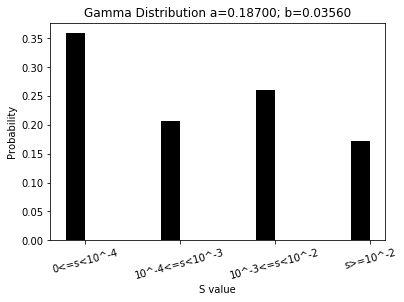

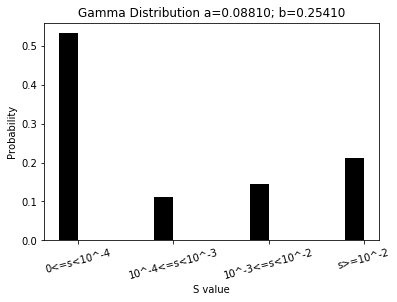

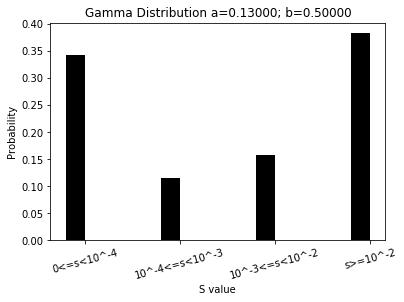

In [3]:
# Plot the following a,b gamma distribution parameter pairs 
a_b_combos = [(0.187, 0.0356),(0.0881, 0.2541),(0.13, 0.5)] # Correspond to priors 1, 2, and 3
    
fig_num = 0
num_sims = 1000

for combo in a_b_combos:
    
    a = combo[0]
    b = combo[1] 

    svals = GetGammaBins(a, b, num_sims)

    # Plot discrete pdf of gamma distribution
    fig_num = fig_num + 1
    plt.figure(fig_num)
    x = ['0<=s<10^-4', '10^-4<=s<10^-3', '10^-3<=s<10^-2', 's>=10^-2']
    y_pos = np.arange(len(x))
    barWidth = 0.2
    r1 = np.arange(len(x))

    plt.bar(r1, svals, color='black', width=barWidth) 
    plt.xticks([r + barWidth/2 for r in range(len(x))], x)
    plt.xticks(rotation=15) 
    plt.xlabel("S value")
    plt.ylabel("Probability")
    plt.title("Gamma Distribution a=%.5f; b=%.5f"%(a, b)) 
    plt.savefig(PLOTDIR + "gamma_distribution_pdf_discrete_a_%.4f_b_%.4f.pdf"%(a, b), bbox_inches='tight')

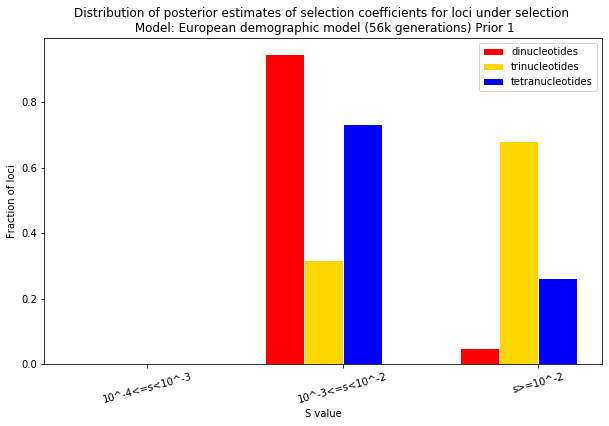

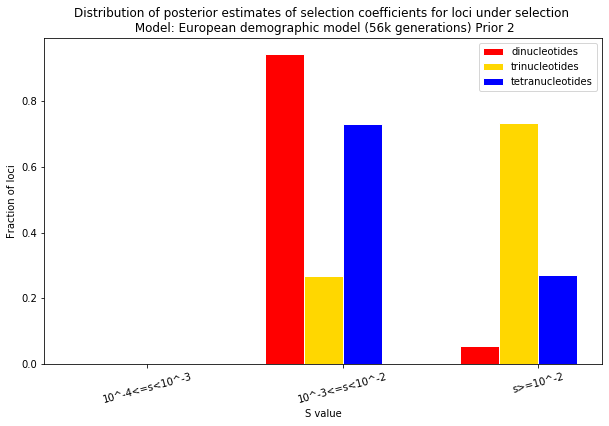

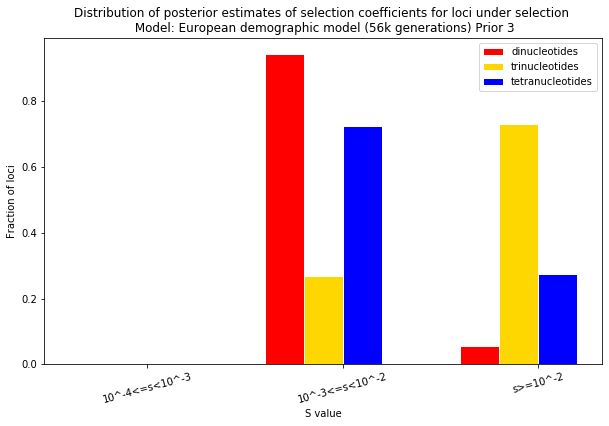

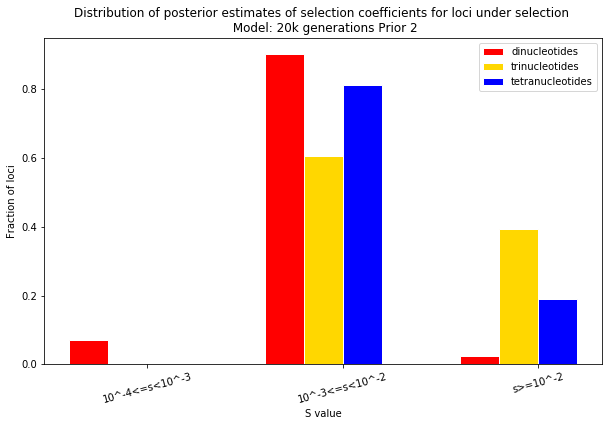

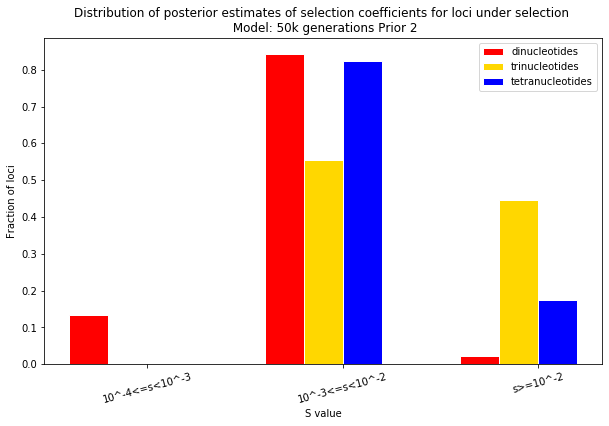

In [4]:
# Graph inferred genome-wide distribution of s
# Different combinations of prior and model to graph
# Prior options - 1, 2, 3
# Model options - 20k gens, 50k gens, eurodem (European demographic model)

combos = [('1','eurodem'),('2','eurodem'),('3','eurodem'),('2','20k'),('2','50k')]
    
fig_num = 0

for combo in combos:
        
    fig_num = fig_num + 1
    prior = combo[0] 
    model = combo[1] 
        
    if model == 'eurodem':
        model_name = 'European demographic model (56k generations)'
    if model == '20k':
        model_name = '20k generations'
    if model == '50k':
        model_name = '50k generations'
        
    total_threshold = 5214 # Threshold for 'total' column, filter out loci with 'total' value < 5214
        
    inFile = '/storage/BonnieH/selection_project/per_locus/SISTR_results_processed/0.005_3_0.3_yny5_%s_prior%s_all_per_0810.txt'%(model, prior)
    results_file = open(inFile, 'r')
    svals_dic = {} # Dictionary of s values
    svals_dic_normalized = {} # Dictionaries of normalized s values

    periods = [2,3,4]

    # Initialize dictionaries above
    # Key: period, value: list of binned s values
    # Bins: 0<=s<10^-4, 10^-4<=s<10^-3, 10^-3<=s<10^-2, s>=10^-2
    for per in periods:
        svals_dic[per] = [0,0,0,0] 
        svals_dic_normalized[per] = [0,0,0,0]

    header = results_file.readline().strip()

    # Read each line of results file
    for line in results_file:

        # Get information from line
        info = line.strip().split('\t')
        chrom = info[0]
        start = int(info[1])
        end = int(info[2])
        per = int(info[4])
        optimal_ru = int(info[5])
        ABC_s = info[17]
        total_n = int(info[3])
            
        if ABC_s != 'N/A' and total_n > total_threshold: 
            p_val = float(info[25])
            ABC_s = float(info[17])
                
            # Only plot loci under selection (adjusted p value < 0.01)
            if p_val < 0.01:
                if ABC_s < 10**-4:
                    svals_dic[per][0] += 1
                elif ABC_s < 10**-3:
                    svals_dic[per][1] += 1
                elif ABC_s < 10**-2:
                    svals_dic[per][2] += 1
                elif ABC_s >= 10**-2:
                    svals_dic[per][3] += 1

    results_file.close()

    plt.figure(num=fig_num, figsize=(10,6))

    # Fill in svals_dic_normalized (normalized version of svals_dic)
    for per in periods:
        sum_of_list = sum(svals_dic[per])
        for i in range(0, len(svals_dic[per])):
            svals_dic_normalized[per][i] = svals_dic[per][i]/sum_of_list
        
    x = ['10^-4<=s<10^-3', '10^-3<=s<10^-2', 's>=10^-2']
    y_pos = np.arange(len(x))

    barWidth = 0.2
    r1 = np.arange(len(x))
    r2 = [y + barWidth for y in r1]
    r3 = [y - barWidth for y in r1]

    # Make the plot
    plt.bar(r3, svals_dic_normalized[2][1:], color='red', width=barWidth, edgecolor='white', label='dinucleotides') 
    plt.bar(r1, svals_dic_normalized[3][1:], color='gold', width=barWidth, edgecolor='white', label='trinucleotides') 
    plt.bar(r2, svals_dic_normalized[4][1:], color='blue', width=barWidth, edgecolor='white', label='tetranucleotides') 

    plt.xticks([r + barWidth/2 for r in range(len(x))], x)
    plt.xlabel("S value")
    plt.ylabel("Fraction of loci")
    plt.xticks(rotation=15)
    plt.title("Distribution of posterior estimates of selection coefficients for loci under selection \n Model: %s Prior %s"%(model_name, prior))
    plt.legend() 
    plt.savefig(PLOTDIR + "%s_prior_%s.pdf"%(model, prior),bbox_inches='tight')